In [1]:
pip install -e .

Obtaining file:///C:/Users/NHT/gym-foo
  Attempting uninstall: gym-foo
    Found existing installation: gym-foo 0.0.1
    Uninstalling gym-foo-0.0.1:
      Successfully uninstalled gym-foo-0.0.1
  Running setup.py develop for gym-foo
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import math
import gym
import gym_foo
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

In [3]:
env = gym.make("foo-v0", map_name = "8x8")

def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action
    
def Expected_SARSA(env, num_episodes, alpha, epsilon, gamma):
  
    Q = defaultdict(lambda: np.zeros(4))
    pi = defaultdict(lambda: np.zeros(4))
    rolling = []
    rolling_avg = []

    for episode in tqdm(range(1, num_episodes)):
        state = env.reset()
        t = 0
        returns = 0
        rewards = []
        
        while True:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            rewards.append(reward)
            _max = np.max(Q[next_state][:])
            _maxcnt = 0
            for _a in range(4):
                if Q[next_state][_a] == _max:
                    _maxcnt += 1
            for _a in range(4):
                if Q[next_state][_a] == _max:
                    pi[next_state][_a] = 1. / _maxcnt
                else:
                    pi[next_state][_a] = 0.
            next_state_type = env.desc.flatten()[int(next_state)]
            Q[state][action] += alpha * \
                  (reward + gamma * np.sum(pi[next_state][:] * Q[next_state][:]) - Q[state][action])
            state = next_state
            t += 1
            if done:
                break

        rolling.append(np.sum(rewards))
        rolling_avg.append(np.mean(rolling))

    return rolling, Q, rolling_avg

er, q, avgs = Expected_SARSA(env = env, num_episodes = 10000, alpha = .85, epsilon = .1, gamma = 1)

100%|██████████████████████████████████████████████████████████████████████████████| 9999/9999 [01:48<00:00, 92.11it/s]


Text(0, 0.5, 'Average Reward So Far')

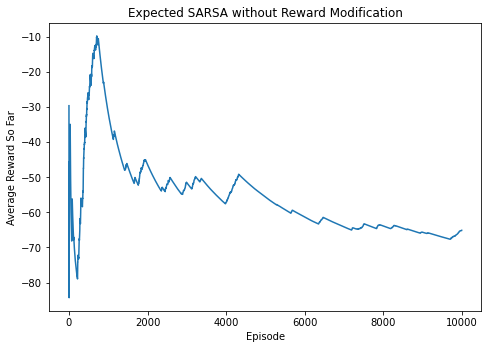

In [4]:
plt.axes([1, 1, 1, 1])
plt.plot(avgs)
plt.title("Expected SARSA without Reward Modification")
plt.xlabel("Episode")
plt.ylabel("Average Reward So Far")

In [15]:
class LinearQLearner():
    """
    A Linear Q-Learner that just acts greedily all the time. 

    Attributes:
      env : An OpenGym environment (spoiler: it's MountainCar)
      num_actions : An integer. The number of actions. For convenient reference.
      state_size : An integer. The number of features. For convenient refernece.
      gamma : A float; the discount factor
      alpha : A float; the learning rate.
      epsilon : A float indicating the exploration probability during action
        selection.
      epsilon_decay : A float indicating how much epsilon will be decayed
        between episodes.
      weights : A numpy array (state_size x num_actions) storing the weights.
        This is a stacked representation, in which each action has its own
        weights. For example, the weights for action 0 are stored in column 0,
        the weights for action 1 are stored in column 1 ...

    """

    def __init__(self, gamma, alpha, epsilon, epsilon_decay):
        self.env = gym.make("foo-v0")
        self.num_actions = self.env.action_space.n
        self.state_size = 64
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.weights = np.zeros(
            (self.state_size, self.env.action_space.n)
        )
    
    def reset(self):
      """
      Resets the weights to 0 for fresh runs.
      """
      self.weights = np.zeros((self.state_size, self.num_actions))

    def estimate_action_values(self, state):
      """
      Arguments:
        state: A numpy array storing the continuous state vector.
      Returns:
        action_values: A numpy array storing the estimated Q values for each 
          action available in the given state.
      """
      action_values = np.dot(
          state, 
          self.weights
          )
      return action_values

    def update_weights(self, delta, state, action):
      """
      Calculates and applies the gradient update to the weights for the chosen
      action.
      Arguments:
        delta: A float; the TD-error.
        state: A numpy array storing the state vector.
        action: An integer; the index of the chosen action.
      """
      delta_vector = np.zeros((1, self.num_actions))
      delta_vector[0,action] = self.alpha * delta
      update =  np.dot(state.T, delta_vector)
      self.weights += update

    def choose_action_epsilon_greedy(self, state, epsilon):
      """
      Chooses an action according to the epsilon-greedy policy.
      Arguments:
        state: A numpy array storing the state vector.
        epsilon: A float; the probabilty to choose a random action.
      Returns:
        action: The index of the chosen action.
        action_value: The vector of Q-values for all available actions.
        action_max: The greedy action (for convenience).
      """
      action_values = self.estimate_action_values(state)
      if np.random.random() < epsilon:
          action = np.random.choice(self.env.action_space.n)
      else:
          action = np.random.choice(
              np.where(action_values == action_values.max())[0]
              )
      action_value = action_values[action,0]
      action_max = np.max(action_values)
      return action, action_value, action_max

    def run_episode(self, epsilon, episode):
        """
        Runs an epsiode.
        Arguments:
          epsilon: A float; the probability of choosing a random action.
          episode: An integer, the current episode number.
        Returns:
          episode_return: A float. The total reward collected over the episode.
        """
        episode_return = 0
        state = self.env.reset()
        done = False

        while not done:
          action, action_value, _ = self.choose_action_epsilon_greedy(state, epsilon)
          next_state, reward, done, _ = self.env.step(action)
          next_state = next_state.reshape((1,self.state_size))
          next_action, _, max_q = \
            self.choose_action_epsilon_greedy(next_state, epsilon)

          """
          Below, I multiply the gamma*q component by (1-done) because:
          If the episode is done we don't need the gamma*q, so this 
          eliminates that component when we need it to be gone.
          1 - True = 1 - 1 = 0
          1 - False = 1 - 0 = 1
          """
          target = reward + (( self.gamma * max_q ) * (1-done))
          delta = target - action_value
          self.update_weights(delta, state, action)
          episode_return += reward
          state = next_state

        return episode_return

    def learn_task(self, num_episodes, print_progress):
      """
      This... learns the task.
      Arguments:
        num_episodes: An integer. The number of episodes to run.
        print_progress: Boolean. Do we want the progress printed as we go?
      Returns:
        returns: A list of the rewards collected from each episode.
        rolling_100_episode_avg: A list of the average of the last 100 episode 
          returns. Starts at episode 101,
      """
      epsilon = self.epsilon
      returns = []
      rolling_100_episode_avg = []

      for episode in tqdm( range(1, num_episodes), position=0, leave=True ):
        episode_return = self.run_episode(epsilon, episode)
        returns.append(episode_return)
        if episode > 100:
          avg = sum(returns[episode-100:episode])/100
          rolling_100_episode_avg.append(avg)
          if avg >= -110:
            print('Solved in {} Episodes!'.format(episode))
            break
          if print_progress and episode % 100 == 0:
            print('Average Reward for Last 100 Episodes = {}'.format(avg))
            
        epsilon *= self.epsilon_decay
      
      return returns, rolling_100_episode_avg

In [16]:
gamma = 1.
alpha = .008 # just because, though I've tried many (see hyper search below)
epsilon = 0.
epsilon_decay = .9999

agent = LinearQLearner(gamma, alpha, epsilon, epsilon_decay)

ret, avg = agent.learn_task(2000, print_progress = True)

plt.plot(avg)

  0%|                                                                                         | 0/1999 [00:00<?, ?it/s]


KeyError: 9